In [243]:
from urllib.request import urlopen
from urllib.error import HTTPError
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib as mpl
from matplotlib import cycler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


api = 'xxx' #use your API key from the FMP https://site.financialmodelingprep.com/developer/docs/

In [6]:
def earnings(start, end, api_key, as_reported=False):
    
    if as_reported:
        URL = (f"https://financialmodelingprep.com/api/v3/earning_calendar?from={start}&to={end}&apikey={api_key}")
             
    else:
        URL = (f"https://financialmodelingprep.com/api/v3/earning_calendar?from={start}&to={end}&apikey={api_key}")

    response = urlopen(URL)
    data = json.loads(response.read().decode("utf-8"))

    data_formatted = {}
    

    return data


def quote(ticker, api_key, as_reported=False):
    
    if as_reported:
        URL = (f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?serietype=line&apikey={api_key}")
             
    else:
        URL = (f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?serietype=line&apikey={api_key}")

    response = urlopen(URL)
    data = json.loads(response.read().decode("utf-8"))

    data_formatted = {}

    return data

## Download earnings for the period

In [173]:
start = '2019-01-01'
#start = start.strftime('%Y-%m-%d')
end = '2022-01-01'
#end = end.strftime('%Y-%m-%d')

stock_one = 'AAPL'

# Insert tickers in the following format:

ticker_list = ['FISV',
'FLT',
'FMC',
'F',
'FTNT',
'FTV']

ticker_list2 = ['FISV',
'FLT',
'FMC',
'F',
'FTNT',
'FTV',
'AAPL']

In [90]:
df = earnings(start, end, api, as_reported=False)
df = pd.json_normalize(df)

df = df[df['symbol'].isin(ticker_list2)]
df['date'] = pd.to_datetime(df['date'])#.dt.date
df['EPS_surpise'] = df['eps'] / df['epsEstimated'] - 1

## Stock returns around earnings announcement

In [91]:
FIELDS = ['close','date']

df_initial2 = quote(stock_one, api, as_reported=False)
df_initial2 = pd.json_normalize(df_initial2['historical'])
df_initial2['symbol'] = stock_one

for stock in ticker_list:
    df_new2 = quote(stock, api, as_reported=False)
    df_new2 = pd.json_normalize(df_new2['historical'])
    df_new2 = df_new2[FIELDS]
    df_new2['symbol'] = stock 
    df_initial2 = pd.concat([df_new2,df_initial2],axis = 0)
    
df_initial2 = df_initial2.loc[:, ['symbol','date','close']]

In [92]:
df_1 = df_initial2
df_1['date'] = pd.to_datetime(df_1['date'])#.dt.date

cols = df_1.columns.tolist()
cols = cols[1:2] + cols[0:1] + cols[2:3]
df_1 = df_1[cols]

In [199]:
df_1['return_10'] = df_1.groupby('symbol')['close'].pct_change(periods=10)
df_1['return_1'] = df_1.groupby('symbol')['close'].pct_change(periods=1)

<ipython-input-199-fd20093fd470>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['return_10'] = df_1.groupby('symbol')['close'].pct_change(periods=10)
<ipython-input-199-fd20093fd470>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['return_1'] = df_1.groupby('symbol')['close'].pct_change(periods=1)


In [200]:
df3 = pd.merge_asof(df.sort_values('date'), df_1.sort_values('date'), on='date', by='symbol', tolerance=pd.Timedelta("2 day"))
df_for_ind = df3

## Index return

In [201]:
FIELDS = ['close','date']

df_ind = quote('SPY', api, as_reported=False)
df_ind = pd.json_normalize(df_ind['historical'])
df_ind['symbol'] = 'SPY'
    
df_ind = df_ind.loc[:, ['symbol','date','close']]

In [237]:
df_ind = df_ind.sort_values(['date'],ascending = True)

df_ind['index_return_10'] = df_ind['close'].pct_change(periods=10)

df_ind['date'] = pd.to_datetime(df_ind['date'])

df1 = pd.merge_asof(df_for_ind.sort_values('date'), 
                      df_ind.sort_values('date'), on='date', tolerance=pd.Timedelta("2 day"))

In [238]:
df1.sort_values(['EPS_surpise'],ascending = False)

,date,symbol_x,eps,epsEstimated,time,revenue,revenueEstimated,EPS_surpise,close_x,return_10,return_1,symbol_y,close_y,index_return_10
160,2022-02-09,FOXA,0.13,0.01,amc,4.441000e+09,4.217380e+09,12.000000,43.849998,0.072914,-0.003409,SPY,457.540009,0.055748
164,2022-02-09,MGM,0.12,0.02,amc,0.000000e+00,2.799750e+09,5.000000,48.520000,0.115146,0.030805,SPY,457.540009,0.055748
237,2022-02-25,PNW,0.24,0.06,bmo,7.988570e+08,6.812000e+08,3.000000,71.990000,-0.023997,0.016377,SPY,437.750000,-0.025750
15,2022-01-19,PLD,1.67,0.60,bmo,0.000000e+00,1.103910e+09,1.783333,153.589996,-0.023772,-0.003568,SPY,451.750000,-0.054026
101,2022-02-02,MPC,1.30,0.55,bmo,0.000000e+00,3.067530e+10,1.363636,78.500000,0.005637,0.019878,SPY,457.350006,0.012396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2022-01-12,DGX,NaN,NaN,bmo,0.000000e+00,2.337600e+09,NaN,147.139999,0.089280,0.014689,SPY,471.019989,-0.013529
6,2022-01-14,SHW,NaN,NaN,bmo,0.000000e+00,4.769860e+09,NaN,308.459991,0.076612,0.007315,SPY,464.720001,-0.021560
129,2022-02-03,NWS,0.44,NaN,amc,2.717000e+09,NaN,NaN,22.540001,-0.022550,-0.008359,SPY,446.600006,-0.000336
141,2022-02-07,L,1.37,NaN,bmo,1.430000e+09,NaN,NaN,60.830002,-0.002950,-0.014899,SPY,447.260010,0.016870


In [204]:
df1_sorted = df1.sort_values(['EPS_surpise'],ascending = False)
df1_sorted25 = df1_sorted[df1_sorted['EPS_surpise'] > df1_sorted['EPS_surpise'].quantile(0.75)]
df1_sorted50 = df1_sorted[df1_sorted['EPS_surpise'] > df1_sorted['EPS_surpise'].quantile(0.5)]
df1_sorted75 = df1_sorted[df1_sorted['EPS_surpise'] > df1_sorted['EPS_surpise'].quantile(0.25)]
df1_sorted100 = df1_sorted

In [205]:
print(df1_sorted25['EPS_surpise'].mean())
print(df1_sorted50['EPS_surpise'].mean())
print(df1_sorted75['EPS_surpise'].mean())
print(df1_sorted100['EPS_surpise'].mean())

0.6731249709072782
0.3797613463260003
0.26103016003190715
0.10565417797964864


In [206]:
print(df1_sorted25['return_10'].mean())
print(df1_sorted50['return_10'].mean())
print(df1_sorted75['return_10'].mean())
print(df1_sorted100['return_10'].mean())

-0.010433652148160928
-0.005908820611746963
-0.007033513775032129
-0.0016464284727891849


## Regression

In [214]:
df_test = df1.dropna(subset=['EPS_surpise','return_10','index_return_10'])
y = df_test['return_10']
x = df_test[['EPS_surpise','index_return_10']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 100)

In [218]:
mlr = LinearRegression(fit_intercept = False)  
mlr.fit(x_train, y_train)

x_train1 = sm.add_constant(x_train)
results = sm.OLS(y_train,x_train).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              return_10   R-squared (uncentered):                   0.083
Model:                            OLS   Adj. R-squared (uncentered):              0.071
Method:                 Least Squares   F-statistic:                              6.604
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                     0.00180
Time:                        21:09:21   Log-Likelihood:                          133.23
No. Observations:                 147   AIC:                                     -262.5
Df Residuals:                     145   BIC:                                     -256.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
EPS_surpise        -0.0036      0.007     -0.541      0.589      -0.017       0.010
index_return_10     0.5689      0.157      3.612      0.000       0.258       0.880
==============================================================================
Omnibus:                       76.834   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              575.866
Skew:                           1.679   Prob(JB):                    8.96e-126
Kurtosis:                      12.096   Cond. No.                         23.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [219]:
y_pred_mlr= mlr.predict(x_test)
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})

In [220]:
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))

print("Intercept: ", mlr.intercept_)
print("Coefficients:")
list(zip(x, mlr.coef_))

Intercept:  0.0
Coefficients:


[('EPS_surpise', -0.0036396427252855237),
 ('index_return_10', 0.5688501286567947)]

In [221]:
print('R squared: {:.2f}'.format(mlr.score(x,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared: 2.81
Mean Absolute Error: 0.0637960825400267
Mean Square Error: 0.007039701957689704
Root Mean Square Error: 0.08390293175860844


In [261]:
IPython_default = plt.rcParams.copy()

colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

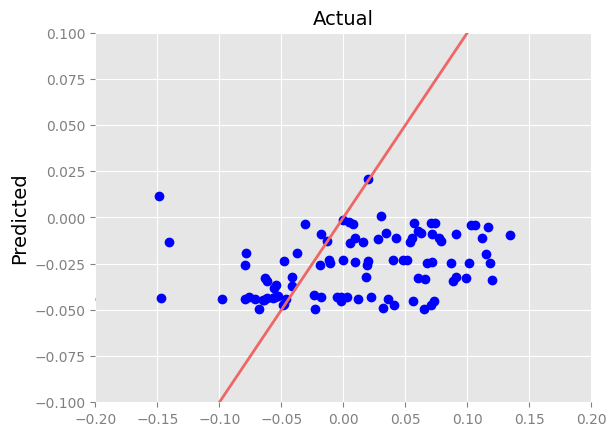

In [262]:
plt.scatter(y_test, y_pred_mlr,color='blue')

plt.title('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.axline([0, 0], [1, 1])
plt.xlim([-0.2, 0.2])
plt.ylim([-0.1, 0.1])

plt.show()

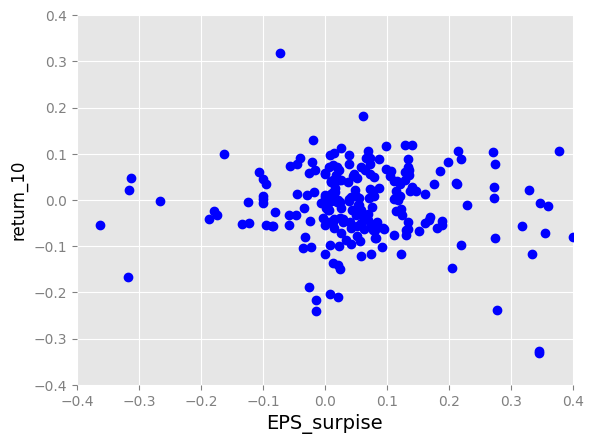

In [292]:
plt.scatter(df_test['EPS_surpise'], df_test['return_10'],color='blue')
plt.ylabel('return_10', fontsize=12)
plt.xlabel('EPS_surpise', fontsize=14)
plt.xlim([-0.4, 0.4])
plt.ylim([-0.4, 0.4])

plt.show()

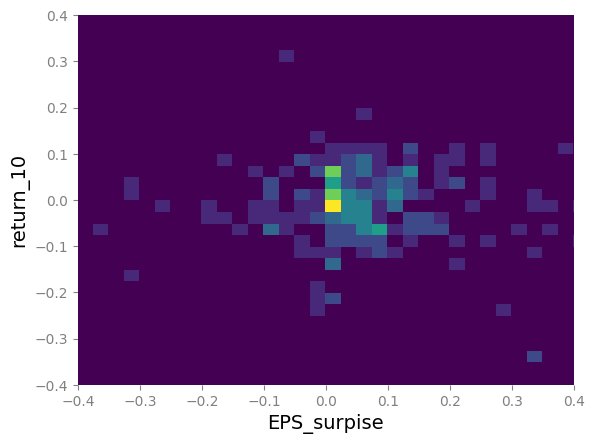

In [265]:
x = df_test['EPS_surpise']
y = df_test['return_10']

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(np.arange(-3, 3, 0.025), np.arange(-3, 3, 0.025)))
ax.set(xlim=(-0.4, 0.4), ylim=(-0.4, 0.4))
plt.ylabel('return_10', fontsize=14)
plt.xlabel('EPS_surpise', fontsize=14)

plt.show()

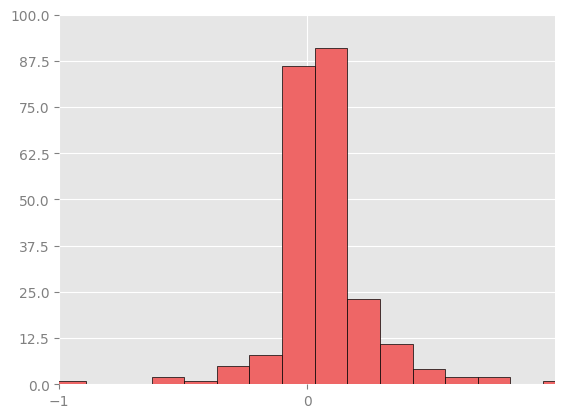

In [284]:
fig, ax = plt.subplots()

ax.hist(df_test['EPS_surpise'], bins=200, linewidth=0.5, edgecolor="black")

ax.set(xlim=(-1, 1), xticks=np.arange(-1, 1),
       ylim=(0, 100), yticks=np.linspace(0, 100, 9))

plt.show()

In [ ]:
df3.to_csv('/Users/daniil_bruk/Desktop/list4.csv', index = True, header=True)